In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


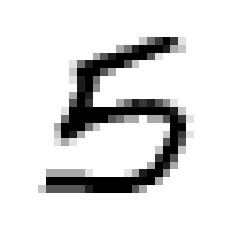

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[27053]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[27053]

'5'

(784,)
(28, 28)


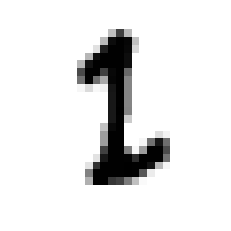

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

five_digit = X_train[27050]
print(five_digit.shape)
five_digit_image = five_digit.reshape(28,28)
print(five_digit_image.shape)
plt.imshow(five_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
'''
Identify one digit - number 5. We will use a binary classifier, 
capable of distinguishing between just two classes, 5 and not-5.
'''
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits.
print(y_train_5[27050])

# Using Stochastic Gradient Descent classifier to train
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([five_digit])

False


array([False])

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96145, 0.96855, 0.96965])

In [8]:
'''
Implementing Cross-Validation
'''
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/cameron/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96145
0.96855
0.96965


In [9]:
'''
Now to classify every single image in the "not-5" class
'''
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9117 , 0.90995, 0.9073 ])

# Confusion Matrix

In [10]:
'''
cross_val_predict() performs K-fold cross-validation, but instead of returning
the evaluation scores, it returns the predictions made on each test fold. This
means that you get a prediction for each instance made by a model that never
saw the data during training. 
'''
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53855,   724],
       [ 1283,  4138]])

In [11]:
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_train_5, y_train_pred))
print("Recall: ", recall_score(y_train_5, y_train_pred))
cfm = confusion_matrix(y_train_5, y_train_pred)
recal = (cfm[1][1]) / (cfm[1][1] + cfm[1][0])
print(recal)

Precision:  0.851090086384204
Recall:  0.7633277992990223
0.7633277992990223


In [12]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8048234950889818

In [13]:
'''
Recall/Precision - decision tradeoff
'''
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-1401.75314776]
[False]


In [14]:
threshold = -300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

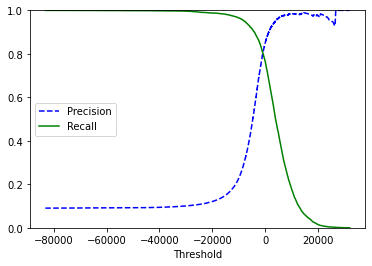

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Precision:  0.8830635969911101
Recall:  0.7146282973621103


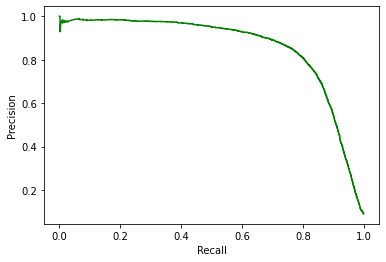

In [16]:
y_train_pred_90 = (y_scores > 800)
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "g-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

# The ROC Curve

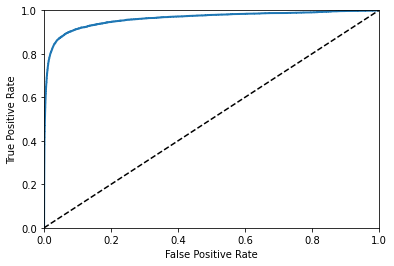

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9618790758631482

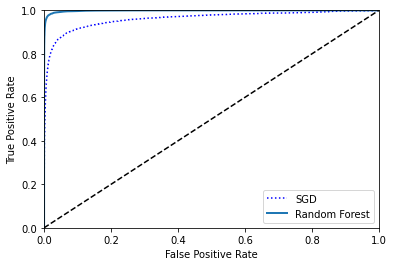

In [19]:
'''
Get scores for each instance in the training set. predict_proba() method returns
an array containing a row per instance and a column per class, each containing the
probability that the given instance belongs to the given class.
'''
from sklearn.ensemble import RandomForestClassifier
import sys

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

# To plot a ROC curve, you need scores, not probabilities.
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
np.set_printoptions(threshold=sys.maxsize)
# print(y_probas_forest)
# print(y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [20]:
print("ROC AUC Score:", roc_auc_score(y_train_5, y_scores_forest))
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("RF Precision Score:", precision_score(y_train_5, y_train_pred_forest))
print("RF Recal Score:", recall_score(y_train_5, y_train_pred_forest))

ROC AUC Score: 0.9984375378065812
RF Precision Score: 0.9903361344537815
RF Recal Score: 0.8695812580704667


# Multiclass Classification

In [21]:
'''
When we use a binary classification algorithm for a multiclass classification task, it
automatically runs one-versus-all (OvA) unless the algorithm is an SVM, then one-versus-one (OvO)
'''
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [22]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-10639.66049731, -25911.64422103, -16822.20977585,
         -3275.21059054,  -9890.93100033,   1938.55433489,
        -19297.74569233, -41444.67185499,  -4747.0608531 ,
        -10419.42936782]])

In [23]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

5
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


In [24]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

['5']
45


In [25]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['5'], dtype=object)

In [26]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.  , 0.  , 0.01, 0.  , 0.94, 0.  , 0.  , 0.02, 0.02]])

In [27]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87065, 0.8648 , 0.8593 ])

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/cameron/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90315, 0.9037 , 0.90105])

# Error Analysis

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/cameron/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5621,    0,   15,   11,    9,   35,   31,    4,  196,    1],
       [   1, 6422,   39,   23,    3,   44,    6,    9,  186,    9],
       [  30,   27, 5259,   96,   71,   24,   64,   40,  337,   10],
       [  30,   22,  105, 5284,    2,  207,   21,   45,  353,   62],
       [  15,   14,   42,   13, 5248,   12,   39,   20,  282,  157],
       [  32,   18,   24,  161,   53, 4518,   79,   20,  453,   63],
       [  25,   20,   40,    3,   41,   92, 5564,    8,  124,    1],
       [  18,   13,   54,   24,   53,   12,    5, 5712,  159,  215],
       [  19,   67,   38,   99,    4,  133,   32,    8, 5400,   51],
       [  23,   21,   29,   63,  125,   34,    1,  174,  349, 5130]])

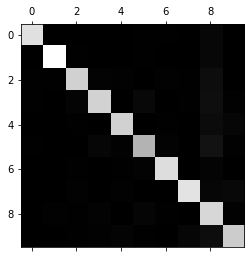

In [30]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

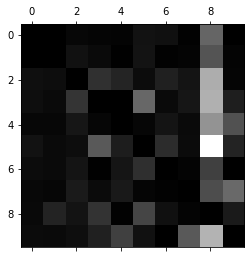

In [31]:
'''
5 class has the least true positives: fewer images of 5s in the dataset or
that the classifier does not perform as well on 5s as on other digits.
'''
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



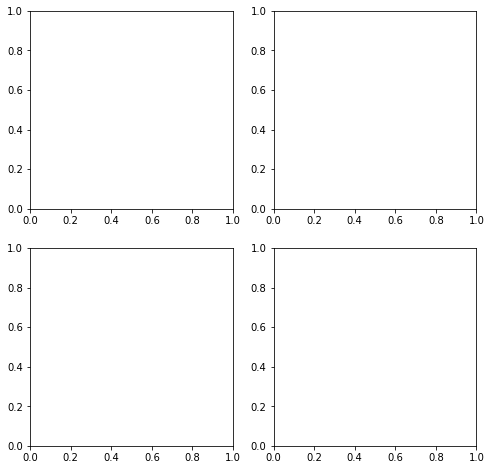

In [32]:
cl_a, cl_b = '3','5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
print(X_aa)

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    print(len(instances) - 1)
#     n_rows = (len(instances) - 1) // images_per_row + 1
#     row_images = []
#     n_empty = n_rows * images_per_row - len(instances)
#     images.append(np.zeros((size, size * n_empty)))
#     for row in range(n_rows):
#         rimages = images[row * images_per_row : (row + 1) * images_per_row]
#         row_images.append(np.concatenate(rimages, axis=1))
#     image = np.concatenate(row_images, axis=0)
#     plt.imshow(image, cmap = matplotlib.cm.binary, **options)
#     plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [33]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
#print(y_multilabel)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [34]:
from sklearn.metrics import classification_report

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1, verbose=2)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

print(classification_report(y_multilabel, y_train_knn_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18065
           1       0.97      0.99      0.98     30508

   micro avg       0.98      0.98      0.98     48573
   macro avg       0.98      0.98      0.98     48573
weighted avg       0.98      0.98      0.98     48573
 samples avg       0.59      0.59      0.59     48573



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.6min finished
/home/cameron/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cameron/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Multioutput Classification

In [35]:
noise = np.random.randint(0, 100, (len(X_train), 784))
print(noise[5500])
print(X_test[5500])
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

[ 3 45 12 42  8 20 12 86 48 19 33  3 79  8 11 35 91 38 38 76 81 84 44 97
 41  5 83 74 59 52 12  9 42 34 80 53 53 38 69 50 44 49 69 25 22 23 51 82
 66 29  2 18 90 77 84 59 30  3 11 44 34 15 22 20 19 77 39  3 24 66 49 44
 68 86 62 95 29 54 77 42 24  7 44 26 98 47 36 71 67 10 46 60 26  4 75 26
 75 12  0 75 29 64 84 35 86 19 47 38 29 52 43 99 75 96 95 49 67 26 61 33
 43 53 46 37 31 73  0 77 26 87 62 98 98 19 96 46 79 92 77 87 68  6 22 70
  2 38 62 69 93 38 35 73 54 31 88 88 60 95 51 15 94 88 43 33 30 55  7 37
 96  3 10 75 38 25 97 41 92 26 83 20  9 13 60 98 57 32 93 16 80 49 67 44
 34 71 88 52 92 77 83 39 46 57 77 48 79  9 35 16 41 17 64 11 24 57 86 22
 90 25 72 25  0 29 15 50 72 82 35 29 74 21 64 69 40 24 35 12 73 71  6 98
 20  5 11 26  9 31  7 62 13 67 39 83 64 38 97  8 94 24 13 20 18 73 42  7
 66 57 83  0 44 36 68 81 58 26 52 94 67 22 45 41 78 54 90 99 38 38 52 59
 19 72 79 71  6 51 15 37 38 36 71 93 88 39  8 36 51 52 51 76 55 56 65 91
 75 40 29 95  0  5 98 69 70 82 48 26 22 64 82 53 27

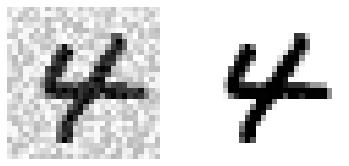

In [36]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

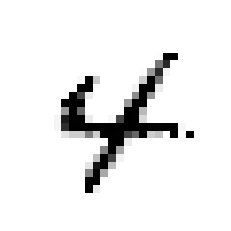

In [37]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercise 1

In [38]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'weights': ['uniform', 'distance'], 'n_neighbors': [2, 5, 10, 30], 'n_jobs': [-1]}
# ]

# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=2)
# grid_search.fit(X_train_scaled, y_train)

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(mean_score), params)
    
'''
0.9665574650962732 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}
0.9721368216460068 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'distance'}
0.9718453237698546 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.9727366892775592 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.9693210682396897 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}
0.9709188088266357 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
0.9622369770487933 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'uniform'}
0.9633016142413549 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'distance'}
0.9665574650962732 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}
0.9721368216460068 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'distance'}
0.9718453237698546 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.9727366892775592 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.9693210682396897 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}
0.9709188088266357 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
0.9622369770487933 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'uniform'}
0.9633016142413549 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'distance'}
0.9665574650962732 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}
0.9721368216460068 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'distance'}
0.9718453237698546 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.9727366892775592 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.9693210682396897 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}
0.9709188088266357 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
0.9622369770487933 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'uniform'}
0.9633016142413549 {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'distance'}
'''

"\n0.9665574650962732 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}\n0.9721368216460068 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'distance'}\n0.9718453237698546 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}\n0.9727366892775592 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}\n0.9693210682396897 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}\n0.9709188088266357 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}\n0.9622369770487933 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'uniform'}\n0.9633016142413549 {'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'distance'}\n0.9665574650962732 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}\n0.9721368216460068 {'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neighbors': 2, 'weigh

In [39]:
# grid_search.best_estimator_
'''
KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')
'''

"\nKNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',\n                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,\n                     weights='distance')\n"

# Exercise 2

In [40]:
from scipy.ndimage.interpolation import shift

def shift_pixel(x_train, direction):
    shifted_array = []
    if direction == 'UP':
        for i in x_train:
            reshape = i.reshape(28,28)
            shifted_image = shift(reshape, [-1,0], cval=0)
            shifted_image = shifted_image.reshape(784,)
            shifted_array.append(shifted_image)
    if direction == 'DOWN':
        for i in x_train:
            reshape = i.reshape(28,28)
            shifted_image = shift(reshape, [1,0], cval=0)
            shifted_image = shifted_image.reshape(784,)
            shifted_array.append(shifted_image)
    if direction == 'LEFT':
        for i in x_train:
            reshape = i.reshape(28,28)
            shifted_image = shift(reshape, [0,-1], cval=0)
            shifted_image = shifted_image.reshape(784,)
            shifted_array.append(shifted_image)
    if direction == 'RIGHT':
        for i in x_train:
            reshape = i.reshape(28,28)
            shifted_image = shift(reshape, [0,1], cval=0)
            shifted_image = shifted_image.reshape(784,)
            shifted_array.append(shifted_image)
    return shifted_array

shifted_up, shifted_down, shifted_left, shifted_right = X_train, X_train, X_train, X_train
shifted_y = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)

shifted_up = shift_pixel(shifted_up, 'UP')
shifted_down = shift_pixel(shifted_down, 'DOWN')
shifted_left = shift_pixel(shifted_left, 'LEFT')
shifted_right = shift_pixel(shifted_right, 'RIGHT')

# for i in X_train[0:2]:
#     digit_image = i.reshape(28,28)
#     plt.imshow(digit_image, cmap=matplotlib.cm.binary,
#               interpolation="nearest")
#     plt.axis("on")
#     plt.show()
    
# for i in shifted_up[0:2]:
#     digit_image = i.reshape(28,28)
#     plt.imshow(digit_image, cmap=matplotlib.cm.binary,
#               interpolation="nearest")
#     plt.axis("on")
#     plt.show()

shifted_train = []
shifted_entries = [X_train, shifted_up, shifted_down, shifted_left, shifted_right]
for x in shifted_entries:
    for y in x:
        shifted_train.append(y)
        
shifted_x = np.asarray(shifted_train)
shifted_y = np.asarray(shifted_y)
# print(shifted_x.shape)
# print(shifted_y.shape)

X_train_shifted, X_test_shifted, y_train_shifted, y_test_shifted = \
        shifted_x[:240000], shifted_x[240000:], shifted_y[:240000], shifted_y[240000:]

###############################
# Stochastic Gradient Descent #
###############################
shifted_sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)

# print(y_train_shifted[59274])
# shifted_sgd_clf.fit(X_train_shifted, y_train_shifted)
# yeet_score = shifted_sgd_clf.predict([X_train_shifted[59274]])
# print("SGD predict: {}".format(yeet_score))

cross_score = cross_val_score(shifted_sgd_clf, X_train_shifted, y_train_shifted, cv=3, scoring="accuracy", n_jobs=-1, \
                              verbose=4)
print("CV Score: {}".format(cross_score))
# CV Score: [0.8167375 0.802225  0.8029125]
# CV Score: [0.82235   0.8171875 0.8171   ]

# y_train_pred_shifted = cross_val_predict(shifted_sgd_clf, X_train_shifted, y_train_shifted, cv=3, n_jobs=-1, \
#                                         verbose=4)
# conf_mx_shifted = confusion_matrix(y_train_shifted, y_train_pred_shifted)
# conf_mx_shifted

'''
       [[21215,     4,   237,   261,    36,  1012,   283,    69,   499,   76],
       [    71, 23716,   183,   379,   126,   299,  1597,    39,   493,   65],
       [   191,   218, 19698,   904,   260,   543,   810,   346,   712,   150],
       [  152,    158,  1092, 18422,    75,  2809,   243,   309,   877,   387],
       [   80,    223,   345,   123, 19965,   607,   469,   172,   418,   966],
       [  450,     74,   299,   985,   336, 17374,   934,    93,   954,   185],
       [  206,    113,   562,    83,   203,   949, 21095,    30,   399,   32],
       [  239,    312,   568,   368,   498,   399,    46, 20943,   360,   1327],
       [  280,    498,   444,  1602,   219,  4459,   444,   150, 14763,   545],
       [  168,    376,   234,   746,  2216,  1195,    32,  1380,   890,   16559]])
'''

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


CV Score: [0.8154875 0.763025  0.7737   ]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min finished


'\n       [[21215,     4,   237,   261,    36,  1012,   283,    69,   499,   76],\n       [    71, 23716,   183,   379,   126,   299,  1597,    39,   493,   65],\n       [   191,   218, 19698,   904,   260,   543,   810,   346,   712,   150],\n       [  152,    158,  1092, 18422,    75,  2809,   243,   309,   877,   387],\n       [   80,    223,   345,   123, 19965,   607,   469,   172,   418,   966],\n       [  450,     74,   299,   985,   336, 17374,   934,    93,   954,   185],\n       [  206,    113,   562,    83,   203,   949, 21095,    30,   399,   32],\n       [  239,    312,   568,   368,   498,   399,    46, 20943,   360,   1327],\n       [  280,    498,   444,  1602,   219,  4459,   444,   150, 14763,   545],\n       [  168,    376,   234,   746,  2216,  1195,    32,  1380,   890,   16559]])\n'

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

############################
# Random Forest Classifier #
############################
# shifted_rfc = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_features='sqrt', \
#                                      n_estimators=200, random_state=42, n_jobs=-1)
# shifted_rfc.fit(X_train_shifted, y_train_shifted)
# y_train_pred_shifted_rfc = cross_val_predict(shifted_rfc, X_train_shifted, y_train_shifted, cv=5, \
#                                         verbose=4)

# shifted_rfc_param_grid = [
#     { 'n_estimators': [10, 50, 100, 200], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample'], 'random_state': [42]}
# ]

# shifted_rfc_grid_search = GridSearchCV(RandomForestClassifier(), shifted_rfc_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=10)
# shifted_rfc_grid_search.fit(X_train_shifted, y_train_shifted)

# shifted_cvres = shifted_rfc_grid_search.cv_results_
# for mean_score, params in zip(shifted_cvres["mean_test_score"], shifted_cvres["params"]):
#     print(np.sqrt(mean_score), params)
    
'''
0.9753482284121229 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9853446943413593 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9864667590277265 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9869333817436717 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9690760204098198 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9832026749353361 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9847652004412016 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9854800014882764 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9753183241041529 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9854715453358696 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9864773185431077 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9869122723592676 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9688094067806458 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.983291665783861 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9846763427644639 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9854504046373922 {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9794343605707666 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9881084623326194 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.988810312109119 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9892421341612984 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9738390524106126 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9858815851815065 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9871866591481067 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9877837145178425 {'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9794343605707666 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9881084623326194 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.988810312109119 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9892421341612984 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}
0.9738390524106126 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}
0.9858815851815065 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
0.9871866591481067 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9877837145178425 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_features': 'log2', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}

'''
    
# shifted_rfc_grid_search.best_estimator_
'''
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
'''



"\nRandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',\n                       criterion='gini', max_depth=None, max_features='sqrt',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, n_estimators=200,\n                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,\n                       warm_start=False)\n"

In [42]:
# predicted = []

# for index in range(len(X_test_shifted)):
#     predicted.append(shifted_rfc.predict([X_test_shifted[index]]))

# print(predicted)
# for index in range(len(predicted)):
#     print("Predicted: {}    Actual: {}".format(predicted[index], y_test_shifted[index]))

# shifted_digit = shifted_rfc.predict([X_test_shifted[some_index]])
# print("Predicted: {}".format(shifted_digit))
# print("Actual: {}".format(y_test_shifted[4000]))

In [43]:
# conf_mx_rfc_shifted = confusion_matrix(y_train_shifted, y_train_pred_shifted_rfc)
# conf_mx_rfc_shifted

'''
[[23475,     4,    18,    12,    16,    16,    53,     2,    66, 30],
[     2, 26692,   105,    28,    31,     7,    25,    47,    17, 14],
[    62,    19, 23309,    65,    60,     9,    32,   171,    86, 19],
[    24,    16,   214, 23751,     4,   143,     8,   153,   138, 73],
[    47,    25,    15,     5, 22859,     0,    80,    47,    34, 256],
[    59,     8,    39,   136,    26, 21136,   137,    15,    83, 45],
[    81,    27,     5,     0,    32,    76, 23407,     0,    44, 0],
[    11,    51,   154,    18,    75,     0,     1, 24529,    36, 185],
[    54,    42,    58,   113,    58,    92,    72,    11, 22694, 210],
[   100,    34,    19,   190,   155,    59,    12,   123,   113, 22991]])
'''

'\n[[23475,     4,    18,    12,    16,    16,    53,     2,    66, 30],\n[     2, 26692,   105,    28,    31,     7,    25,    47,    17, 14],\n[    62,    19, 23309,    65,    60,     9,    32,   171,    86, 19],\n[    24,    16,   214, 23751,     4,   143,     8,   153,   138, 73],\n[    47,    25,    15,     5, 22859,     0,    80,    47,    34, 256],\n[    59,     8,    39,   136,    26, 21136,   137,    15,    83, 45],\n[    81,    27,     5,     0,    32,    76, 23407,     0,    44, 0],\n[    11,    51,   154,    18,    75,     0,     1, 24529,    36, 185],\n[    54,    42,    58,   113,    58,    92,    72,    11, 22694, 210],\n[   100,    34,    19,   190,   155,    59,    12,   123,   113, 22991]])\n'

# Exercise 3